In [25]:
import os 
import numpy as np
import pandas as pd
from pyts.image import RecurrencePlot
import scipy.signal as scisig
from sklearn.utils.validation import check_array
from PIL.Image import Resampling
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import torch 
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torchvision
# from torchvision import transform

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

plt.style.use('ggplot')

EVAL_DICT = {'accuracy ' : accuracy_score, "recall" : recall_score, "f1 score" : f1_score, "confusion_matrix" : confusion_matrix}


In [26]:
classification_models = torchvision.models.list_models(module=torchvision.models)

for m in classification_models:
    print(m)

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
googlenet
inception_v3
maxvit_t
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_128gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext101_64x4d
resnext50_32x4d
shufflenet_v2_x0_5
shufflenet_v2_x1_0
shufflenet_v2_x1_5
shufflenet_v2_x2_0
squeezenet1_0
squeezenet1_1
swin_b
swin_s
swin_t
swin_v2_b
swin_v2_s
swin_v2_t
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19
vgg19_bn
vit_b_16
vit_b_32
vit_h_14
vit_l_16
vit_l_32
wi

In [27]:
mobile_netv3 = torchvision.models.mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT)

In [ ]:
def show_trainable_params(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")



In [29]:
def evaluate_model(preds, labels):
    res = {}
    for mname, metric in EVAL_DICT.items():

        if 'f1' in mname:
            res[mname] = metric(labels, preds, average='binary')

        else:
            res[mname] = metric(labels, preds)

    return res


def display_metrics(metrics):

    for mname, value in metrics.items():
        if mname != 'confusion_matrix':
            print(f"{mname}\t:{value:.4f}")
        else:
            print(mname)
            print(value)

In [30]:
def butter_filter(data, cutoff, order, btype, fs= 20):

    nyq = 0.5 * fs
    normal_cutoff = np.array(cutoff) / nyq
    b, a = scisig.butter(order, normal_cutoff.tolist(), btype=btype, analog=False)
    y = scisig.lfilter(b, a, data)
    return y


def recover_data_from_df(csv_path= "../data/processed/final/train_val_test", filter= False):

    data_splits = {t.split('.')[0] : t for t in os.listdir(csv_path)}
    final_data = {key : [] for key in data_splits}
    final_targets = {key : [] for key in data_splits}
    final_names = {key : [] for key in data_splits}


    for dt, dpath in data_splits.items(): 
        final_path = os.path.join(csv_path, dpath)

        for sample, df in pd.read_csv(final_path).groupby('sample'):
            
            label = df['label'].iloc[0]
            workout = df['Workout'].iloc[0]
            df.drop(columns=['sample', 'label', 'Workout'], inplace=True)

            apn_obj = df.T.values

            if filter:
                apn_obj = butter_filter(df.T.values, (.1, 5), 3, 'bandpass')

            final_data[dt].append(apn_obj)
            final_targets[dt].append(label)
            final_names[dt].append(workout)


        final_targets[dt] = np.array(final_targets[dt])

    return final_data, final_targets, final_names

ft, fy, fn = recover_data_from_df(filter=False)

In [31]:
shapes = np.array([k.shape[-1] for k in ft['validation_data']])

shapes.min(), shapes.mean(), shapes.max()

len(shapes[shapes < 600]) , len(shapes), (40/383)

(10, 107, 0.10443864229765012)

In [32]:
def norm_2(arr):
    return np.sqrt(np.sum(arr**2, axis=0)).reshape(1, -1)

def norm_3(arr):
    return np.cbrt(np.sum(arr**3, axis=0)).reshape(1, -1)

def min_max_norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def transform_one_rp(data):
    rp = RecurrencePlot(threshold='distance', percentage=10)

    ### extracting ACC and GYR resultant channels
    acc = min_max_norm(norm_3(data[0:3]))
    gyr = min_max_norm(norm_3(data[3:6]))
    cap = min_max_norm(data[-1].reshape(1, -1))


    rp_acc = rp.transform(acc)
    rp_gyr = rp.transform(gyr)
    rp_cap = rp.transform(cap)

    rp = np.concat([rp_acc, rp_cap,])



$$P[i,j] = \left\lfloor 255  \times \frac{d(x[i], x[j]) - d_{min}}{d_{max} - d_{min}}  \right\rfloor$$

equacao do paper nao funciona, so gera imagens pretas

In [33]:
class RecurrenceTransformer():

    def __init__(self, output_size):
        self.resizer = torchvision.transforms.Resize(size=(output_size,output_size))

    def get_distance_matrix(self, X, e = 0.1):

        X = check_array(X)
        d = np.abs(X[:, :, None] - X[:, None, :])
        for i, ch in enumerate(d):
            MinMaxScaler((0,1), copy=False).fit_transform(ch)

        return d

    def resize_img(self, sample):
        y_size, x_size = sample.shape[1], sample.shape[2]
        
        print(sample.shape)

        torch_img = torch.from_numpy(sample.reshape(-1, y_size, x_size))
        img = self.resizer.forward(torch_img)
        return img       


In [34]:
rt = RecurrenceTransformer(output_size=224)

dist = rt.get_distance_matrix(ft['train_data'][0])


In [35]:
class Ts2RecurrencePlot(Dataset):

    def __init__(self, x, y, output=224):

        self.x = x
        self.y = y
        self.rt = torchvision.transforms.Resize(size=(output,output))

    def __get_distance_matrix(self, X, e = 0.1):

        X = check_array(X)
        d = np.abs(X[:, :, None] - X[:, None, :])
        for i, ch in enumerate(d):
            MinMaxScaler((0,1), copy=False).fit_transform(ch)

        return d

    def __resize_img(self, sample):

        if len(sample.shape) == 2:
            # triplicating channels for CAP
            sample = np.stack([sample, sample, sample])
        
        y_size, x_size = sample.shape[1], sample.shape[-1]  

        torch_img = torch.from_numpy(sample.reshape( -1, y_size, x_size).astype(np.float32))
        img = self.rt.forward(torch_img)
        return img       


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        t = self.x[idx]
        dist_matrix = self.__get_distance_matrix(t)

        dm = self.__resize_img(dist_matrix)
        # acc_rp = self.__resize_img(acc_rp)
        # gyr_rp = self.__resize_img(gyr_rp)
        # cap = self.__resize_img(cap)

        return dm, self.y[idx]
    

class Ts2RecurrencePlotResNET(Dataset):

    def __init__(self, x, y, output=224):

        self.x = x
        self.y = y
        self.rt = torchvision.transforms.Resize(size=(output,output))

    def __get_distance_matrix(self, X, e = 0.1):

        X = check_array(X)
        d = np.abs(X[:, :, None] - X[:, None, :])
        for i, ch in enumerate(d):
            MinMaxScaler((0,1), copy=False).fit_transform(ch)

        return d

    def __resize_img(self, sample):

        if len(sample.shape) == 2:
            # triplicating channels for CAP
            sample = np.stack([sample, sample, sample])
        
        y_size, x_size = sample.shape[1], sample.shape[-1]  

        torch_img = torch.from_numpy(sample.reshape( -1, y_size, x_size).astype(np.float32))
        img = self.rt.forward(torch_img)
        return img       


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        t = self.x[idx]
        dist_matrix = self.__get_distance_matrix(t)

        dm = self.__resize_img(dist_matrix)
        # acc_rp = self.__resize_img(acc_rp)
        # gyr_rp = self.__resize_img(gyr_rp)
        # cap = self.__resize_img(cap)

        return dm[:3], self.y[idx]

train_dataset = Ts2RecurrencePlot(ft['train_data'], fy['train_data'])
val_dataset = Ts2RecurrencePlot(ft['validation_data'], fy['validation_data'])
test_dataset = Ts2RecurrencePlot(ft['test_data'], fy['test_data'])


In [36]:
# setting gpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_model(model, criterion, optimizer, dloader, num_epochs=25, device = device):
    best_acc = 0.0
    loss_hist = []
    acc_hist = []
    for epoch in tqdm(range(num_epochs)):

        model.train()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for cap, labels in dloader:

            inputs = cap.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dloader)
        loss_hist.append(epoch_loss)
        acc_hist.append(running_corrects / len(dloader))
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}')

    return model, loss_hist

## Simple CNN

In [106]:
simple_dataset_train = Ts2RecurrencePlot(ft['train_data'], fy['train_data'], output=224)
simple_dataset_val = Ts2RecurrencePlot(ft['validation_data'], fy['validation_data'], output=224)
simple_dataset_test = Ts2RecurrencePlot(ft['test_data'], fy['test_data'], output=224)

dl = DataLoader(simple_dataset_train, batch_size=24, shuffle=True)
d_val = DataLoader(simple_dataset_val, batch_size=len(ft['validation_data']), shuffle=False)
d_test = DataLoader(simple_dataset_test, batch_size=len(ft['test_data']), shuffle=False)




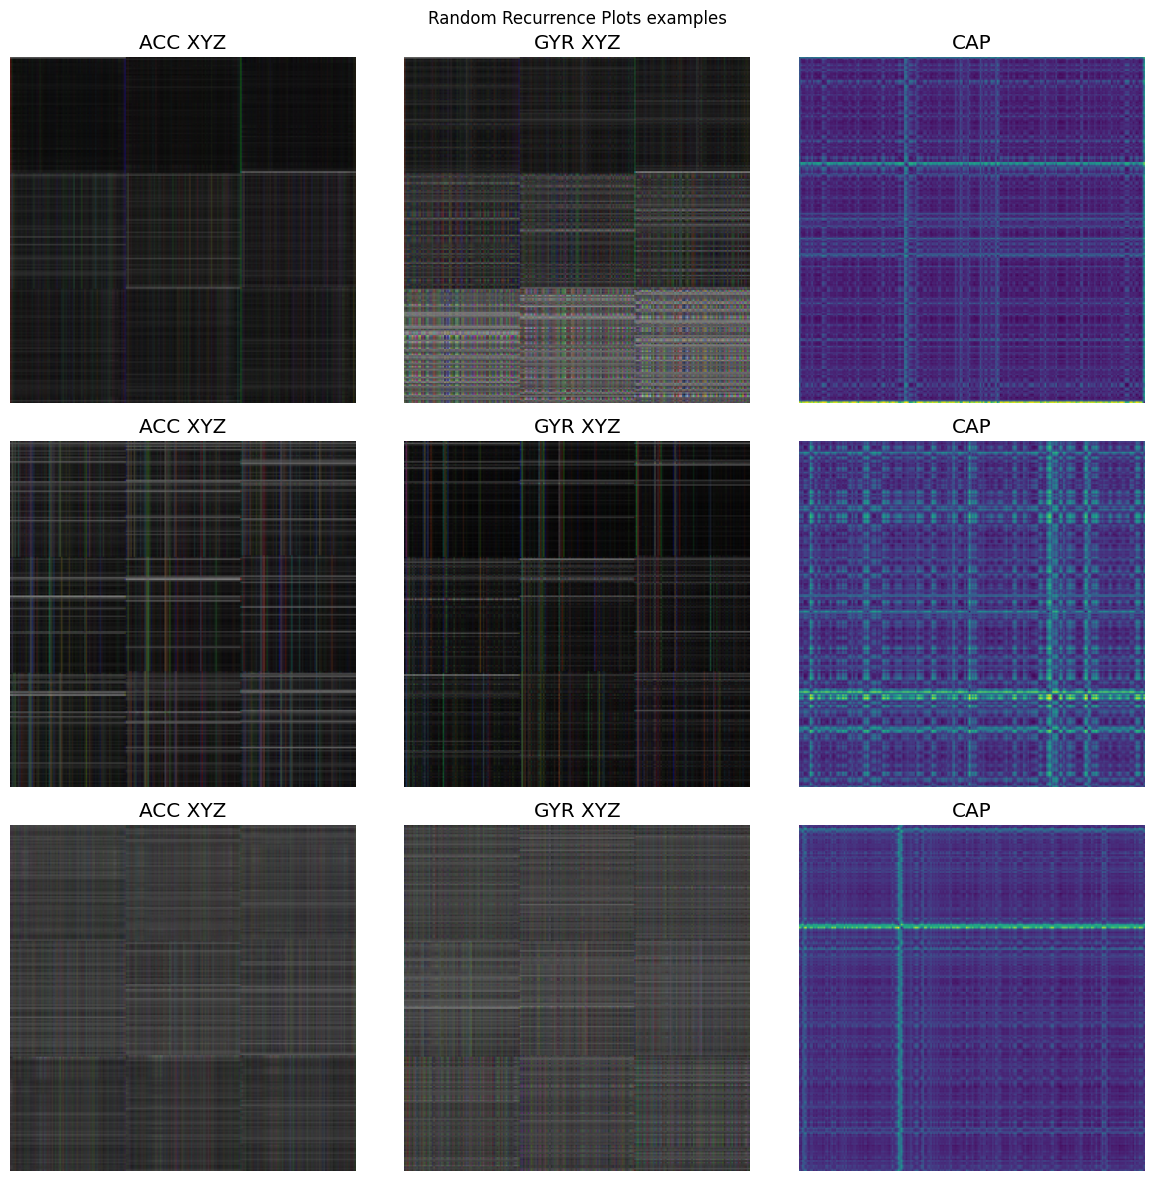

In [107]:
def get_sample_imgs(dataset):

    sample_idx = np.random.randint(0, len(dataset))
    img, y = dataset[sample_idx]
    return img, y

def plot_samples(dataset, size):

    samples = [get_sample_imgs(dataset) for i in range(3)]
    fig, axs = plt.subplots(3,3, figsize=(12,12))

    fig.suptitle("Random Recurrence Plots examples")

    for inx, (x, y) in enumerate(samples):
        axs[inx, 0].imshow(x[:3].reshape(224, 224, 3))
        axs[inx, 1].imshow(x[3:6].reshape(224, 224, 3))
        axs[inx, 2].imshow(x[6].reshape(224, 224,1))
        axs[inx, 0].axis('off')
        axs[inx, 1].axis('off')
        axs[inx, 2].axis('off')
        axs[inx, 0].set_title('ACC XYZ')
        axs[inx, 1].set_title('GYR XYZ')
        axs[inx, 2].set_title('CAP')




    fig.tight_layout()



plot_samples(simple_dataset_train, size = 224)

In [108]:
class SimpleCNN(nn.Module):

    def __init__(self, out_channels):
        super().__init__()
        self.layers = nn.Sequential(

            nn.Conv2d(7, out_channels, kernel_size=5, dilation=5),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(5),
            nn.ReLU(),

            nn.Conv2d(out_channels, 3, kernel_size=4, dilation=2),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(3),
            nn.ReLU(),

            nn.Conv2d(3, 1, kernel_size=4, dilation=2),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(1),

            nn.Flatten(),
            nn.Linear(441,2),

        ) 

    def show_layers(self):
        print("\t \t \t \t Three Blocks CNN")
        print("-" * 90)
        for layer in self.layers:
            print("\t",layer)
            if 'LazyBatchNorm' in layer._get_name(): 
                print("", end='\t')
                print('_' * 80)

    def forward(self, x):
        return self.layers(x)
        # for layer in self.layers:
        #     print("in",x.shape)
        #     x = layer(x)
        #     print("out",x.shape)
    
        # return x
simple_cnn = SimpleCNN(5)


In [109]:
simple_cnn.show_layers()

	 	 	 	 Three Blocks CNN
------------------------------------------------------------------------------------------
	 Conv2d(7, 5, kernel_size=(5, 5), stride=(1, 1), dilation=(5, 5))
	 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
	 BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	 ReLU()
	 Conv2d(5, 3, kernel_size=(4, 4), stride=(1, 1), dilation=(2, 2))
	 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
	 BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	 ReLU()
	 Conv2d(3, 1, kernel_size=(4, 4), stride=(1, 1), dilation=(2, 2))
	 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
	 BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
	 Flatten(start_dim=1, end_dim=-1)
	 Linear(in_features=441, out_features=2, bias=True)


In [110]:
## training 

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
simple_cnn = simple_cnn.to(device)
optimizer_ft = torch.optim.Adam(simple_cnn.parameters(), lr=0.001)
cnn_trained , loss_curve_3cnn = train_model(simple_cnn, criterion, optimizer_ft, dl, 20, device=device)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Loss: 16.7746
Epoch: 2, Loss: 14.7921
Epoch: 3, Loss: 13.4881
Epoch: 4, Loss: 11.4188
Epoch: 5, Loss: 7.8112
Epoch: 6, Loss: 5.6287
Epoch: 7, Loss: 3.8936
Epoch: 8, Loss: 3.4308
Epoch: 9, Loss: 2.7427
Epoch: 10, Loss: 2.7937
Epoch: 11, Loss: 2.1145
Epoch: 12, Loss: 1.7257
Epoch: 13, Loss: 2.1932
Epoch: 14, Loss: 1.7899
Epoch: 15, Loss: 1.5215
Epoch: 16, Loss: 1.9274
Epoch: 17, Loss: 1.1994
Epoch: 18, Loss: 1.0776
Epoch: 19, Loss: 0.9150
Epoch: 20, Loss: 0.9508


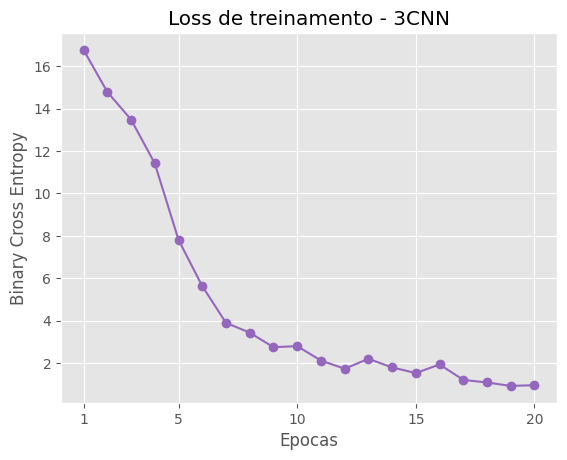

In [111]:
plt.title('Loss de treinamento - 3CNN')
plt.plot(loss_curve_3cnn, color= 'tab:purple', marker='o')
plt.xticks([0, 4, 9, 14,19], labels=[1, 5, 10, 15, 20])

plt.xlabel('Epocas')
plt.ylabel("Binary Cross Entropy")
plt.show()

In [112]:
cnn_trained = cnn_trained.cpu()
preds = []
for x , label in d_val:

    logits = cnn_trained(x)
    _, y_pred = torch.max(logits, 1)
    y_pred = y_pred.detach().numpy()
    
preds = np.array(y_pred)



In [113]:
res = evaluate_model(preds, fy['validation_data'])
display_metrics(res)

accuracy 	:0.9159
recall	:0.9167
f1 score	:0.9072
confusion_matrix
[[54  5]
 [ 4 44]]


In [114]:
cnn_trained = cnn_trained.cpu()
preds = []
for x , label in d_test:

    logits = cnn_trained(x)
    _, y_pred = torch.max(logits, 1)
    y_pred = y_pred.detach().numpy()
    
preds = np.array(y_pred)



In [115]:
res = evaluate_model(preds, fy['test_data'])
display_metrics(res)

accuracy 	:0.9455
recall	:0.9200
f1 score	:0.9388
confusion_matrix
[[29  1]
 [ 2 23]]


## Transfer Learning

In [116]:
dataset_train = Ts2RecurrencePlotResNET(ft['train_data'], fy['train_data'], output=224)
dataset_val = Ts2RecurrencePlotResNET(ft['validation_data'], fy['validation_data'], output=224)
dataset_test = Ts2RecurrencePlotResNET(ft['test_data'], fy['test_data'], output=224)

dl = DataLoader(dataset_train, batch_size=24, shuffle=True)
d_val = DataLoader(dataset_val, batch_size=len(ft['validation_data']), shuffle=False)
d_test = DataLoader(dataset_test, batch_size=len(ft['test_data']), shuffle=False)

In [117]:

model_ft = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)


In [118]:
show_trainable_params(model_ft)

Number of trainable parameters: 5288548


In [119]:
for param in model_ft.parameters():
    param.requires_grad = False


# model_ft.fc = nn.Linear(2048, 2)
#num_features = model_ft.fc.in_features
model_ft.classifier =   nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=2, bias=True)
)
model_ft.to(device)

trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001)


Number of trainable parameters: 2050


In [120]:
dl = DataLoader(dataset_train, batch_size=24, shuffle=True)

model_ft , loss_curve = train_model(model_ft, criterion, optimizer_ft, dl, 20, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (24x1280 and 1024x2)

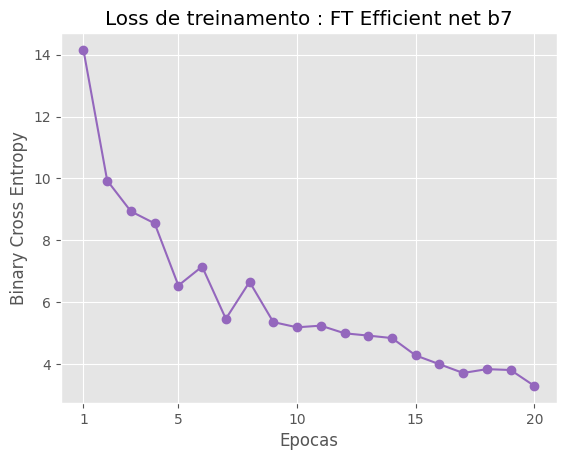

In [ ]:
plt.title('Loss de treinamento : FT Efficient net b7')
plt.plot(loss_curve, color= 'tab:purple', marker='o')
plt.xticks([0, 4, 9, 14,19], labels=[1, 5, 10, 15, 20])
plt.xlabel('Epocas')
plt.ylabel("Binary Cross Entropy")
plt.show()

In [ ]:
model_ft = model_ft.cpu()

for x , label in d_val:
    logits = model_ft(x)
    _, y_pred = torch.max(logits, 1)
    y_pred = y_pred.detach().numpy() 
    
preds = np.array(y_pred)


In [ ]:
res = evaluate_model(preds, fy['validation_data'])
display_metrics(res)

accuracy 	:0.9252
recall	:0.8958
f1 score	:0.9149
confusion_matrix
[[56  3]
 [ 5 43]]


In [ ]:
for x , label in d_test:
    logits = model_ft(x)
    _, y_pred = torch.max(logits, 1)
    y_pred = y_pred.detach().numpy() 
    
preds = np.array(y_pred)
res = evaluate_model(preds, fy['test_data'])
display_metrics(res)

accuracy 	:0.9636
recall	:0.9200
f1 score	:0.9583
confusion_matrix
[[30  0]
 [ 2 23]]
